In [1]:
import sys
sys.path.append("..")

from dapper.mods.Lorenz96 import dstep_dx, step, x0
import dapper.mods as modelling
import dapper as dpr
import dapper.da_methods as da
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hpl.datamodule.observational_models import RandomObservationModel

from mdml_tools.simulators import L96Simulator

## L96 Two level baseline

In [24]:
random_seed: int = 26111997
grid_size: int = 36
forcing: float = 10.0
observation_noise: float = 1.0
mask_fraction: float = 0.75
process_noise: float = 0.0
time_step: float = 0.01
steps_between_observation: int = 1
number_of_observations: int = 2000
number_of_steps_to_cut: int = 500
my_simulation: bool = True

In [25]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Nx = grid_size
Force = forcing
x_initial = x0(grid_size)
dynamical_operator = {
    'M': Nx,
    'model': step,
    'linear': dstep_dx,
    'noise': process_noise,
}

tseq = modelling.Chronology(dt=time_step, dko=steps_between_observation, Ko=number_of_observations, Tplot=0, BurnIn=5)

initial_state_X = x = forcing * (0.5 + torch.randn(torch.Size((1, 1, grid_size)), device="cpu") * 1.0)
initial_state_y = forcing * (0.5 + torch.randn(torch.Size((1, 1, grid_size, 10)), device="cpu") * 1.0)
initial_state_X /= torch.max(torch.tensor([10, 50]))
initial_state_y /= torch.max(torch.tensor([10, 50]))

simulator = L96Simulator(simulator_type='two_level', forcing=forcing)
time_to_simulate = torch.arange(0, (number_of_observations+2)*time_step, time_step, device='cpu', dtype=torch.float32)
xx, _ = simulator.integrate(time_to_simulate, (initial_state_X, initial_state_y))
xx = xx.squeeze()

obs_mod = RandomObservationModel(additional_noise_std=observation_noise, random_mask_fraction=mask_fraction)
observations, mask_array = obs_mod.forward(xx)
xx = xx.numpy()
observations = observations.numpy()
mask_array = np.array(mask_array.numpy(), dtype=bool)
mask_array = mask_array[1:]
observations = observations[1:]

yy = [observations[i, mask_array[i]] for i in range(observations.shape[0])]
yy = np.array(yy)

def observation_operator(t):
    jj = np.flatnonzero(mask_array[t])
    obs = modelling.Operator(**modelling.partial_Id_Obs(grid_size, jj), noise=observation_noise)
    return obs

X0 = modelling.GaussRV(mu=x_initial, C=10)
HMM = modelling.HiddenMarkovModel(dynamical_operator, dict(time_dependent=observation_operator), tseq, X0)

xps = da.OptInterp()
xps.assimilate(HMM, xx, yy)
optimal_interpolation = xps.stats.mu.a

xps = da.Persistence()
xps.assimilate(HMM, xx, yy)
persistence = xps.stats.mu.a

xps = da.EnKS(upd_a="PertObs", N=100, Lag=25)
xps.assimilate(HMM, xx, yy)
enks_perturb_obs = xps.stats.mu.a

result = {
    "random_seed": random_seed,
    "simulation": xx[number_of_steps_to_cut+1:],
    "observations": observations[number_of_steps_to_cut:],
    "mask": mask_array[number_of_steps_to_cut:],
    "optimal_interpolation": optimal_interpolation[number_of_steps_to_cut:],
    "persistence": persistence[number_of_steps_to_cut:],
    "enks_perturb_obs": enks_perturb_obs[number_of_steps_to_cut:],
}

np.save(f"baseline/l96_two_level_{random_seed}.npy", result)

OptInterp:   0%|                                     | 0/2001 [00:00<?, ?it/s]

Persistence:   0%|                                   | 0/2001 [00:00<?, ?it/s]

EnKS:   0%|                                          | 0/2001 [00:00<?, ?it/s]

Assessing:   0%|                                     | 0/2001 [00:00<?, ?it/s]

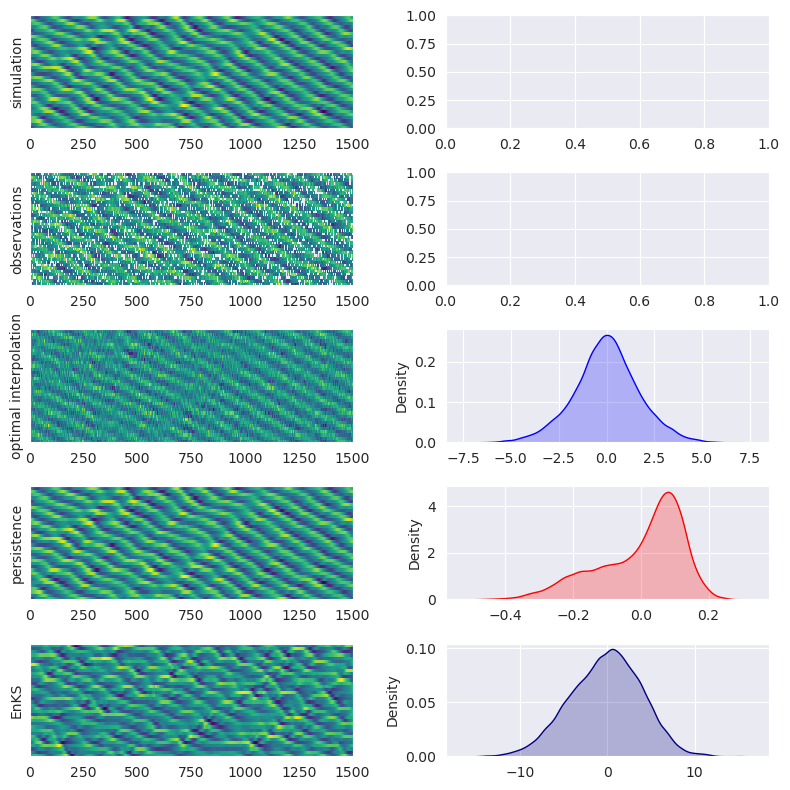

In [26]:
mosaic = """
aaff
bbgg
cchh
ddjj
eekk
"""

fig, axd = plt.subplot_mosaic(mosaic, figsize=(8, 8))

axd["a"].pcolor(result['simulation'].T, cmap='viridis')
observations_plot = result['observations']
observations_plot[observations_plot == 0] = np.nan
axd["b"].pcolor(observations_plot.T, cmap='viridis')
axd["c"].pcolor(result['optimal_interpolation'].T, cmap='viridis')
axd["d"].pcolor(result['persistence'].T, cmap='viridis')
axd["e"].pcolor(result['enks_perturb_obs'].T, cmap='viridis')

error = result['simulation'] - result['optimal_interpolation']
sns.kdeplot(error.flatten(), color='blue', ax=axd["h"], label='Optimal Interpolation', fill=True)

error = result['simulation'] - result['persistence']
sns.kdeplot(error.flatten(), color='red', ax=axd["j"], label='Persistence', fill=True)

error = result['simulation'] - result['enks_perturb_obs']
sns.kdeplot(error.flatten(), color='navy', ax=axd["k"], label='EnKS PertObs', fill=True)


for key, ax in axd.items():
    if key in ['a', 'b', 'c', 'd', 'e']:
        ax.set_yticks([])
    if key == "a":
        ax.set_ylabel("simulation")
    if key == "b":
        ax.set_ylabel("observations")
    if key == "c":
        ax.set_ylabel("optimal interpolation")
    if key == "d":
        ax.set_ylabel("persistence")
    if key == "e":
        ax.set_ylabel("EnKS")

plt.tight_layout()

# L96 One level baseline

In [27]:
def prepare_single_baseline_l96_one_level(
        random_seed: int = 111,
        grid_size: int = 40,
        forcing: float = 8.0,
        observation_noise: float = 1.0,
        mask_fraction: float = 0.75,
        process_noise: float = 0.0,
        time_step: float = 0.01,
        steps_between_observation: int = 1,
        number_of_observations: int = 1500,
        save: bool = False,
):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    dpr.set_seed(random_seed)
    Nx = grid_size
    Force = forcing
    x_initial = x0(grid_size)
    dynamical_operator = {
        'M': Nx,
        'model': step,
        'linear': dstep_dx,
        'noise': process_noise,
    }

    tseq = modelling.Chronology(dt=time_step, dko=steps_between_observation, Ko=number_of_observations, Tplot=0, BurnIn=5)

    X0 = modelling.GaussRV(mu=x_initial, C=0.25)

    initial_state = torch.from_numpy(X0.sample(1)).unsqueeze(0).unsqueeze(0)
    simulator = L96Simulator(simulator_type='one_level', forcing=8)
    time_to_simulate = torch.arange(0, (number_of_observations+2)*time_step, time_step, device='cpu', dtype=torch.float32)
    xx = simulator.integrate(time_to_simulate, initial_state).squeeze()

    obs_mod = RandomObservationModel(additional_noise_std=observation_noise, random_mask_fraction=mask_fraction)
    observations, mask_array = obs_mod.forward(xx)
    xx = xx.numpy()
    observations = observations.numpy()
    mask_array = np.array(mask_array.numpy(), dtype=bool)
    mask_array = mask_array[1:]
    observations = observations[1:]

    yy = [observations[i, mask_array[i]] for i in range(observations.shape[0])]
    yy = np.array(yy)

    def observation_operator(t):
        jj = np.flatnonzero(mask_array[t])
        obs = modelling.Operator(**modelling.partial_Id_Obs(grid_size, jj), noise=observation_noise)
        return obs

    X0 = modelling.GaussRV(mu=x_initial, C=0.25)
    HMM = modelling.HiddenMarkovModel(dynamical_operator, dict(time_dependent=observation_operator), tseq, X0)

    xps = da.OptInterp()
    xps.assimilate(HMM, xx, yy)
    optimal_interpolation = xps.stats.mu.a

    xps = da.EnKS(upd_a="PertObs", N=100, Lag=1)
    xps.assimilate(HMM, xx, yy)
    enks_perturb_obs = xps.stats.mu.a

    result = {
        "random_seed": random_seed,
        "simulation": xx[401:],
        "observations": observations[400:],
        "optimal_interpolation": optimal_interpolation[400:],
        "enks_perturb_obs": enks_perturb_obs[400:],
    }

    if save:
        np.save(f"baseline_data_assimilation_l96_one_level/l96_one_level_{random_seed}.npy", result)
    return result


In [28]:
random_seed = 1150
for i in range(1000):
    _ = prepare_single_baseline_l96_one_level(random_seed=random_seed+i, save=True)

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

OptInterp:   0%|                                                                                     | 0/1501 …

EnKS:   0%|                                                                                          | 0/1501 …

Assessing:   0%|                                                                                     | 0/1501 …

In [ ]:
# mosaic = """
# aaff
# bbgg
# cchh
# ddjj
# """
#
# fig, axd = plt.subplot_mosaic(mosaic, figsize=(8, 8))
#
# axd["a"].pcolor(result['simulation'].T, cmap='viridis')
# observations_plot = result['observations']
# observations_plot[observations_plot == 0] = np.nan
# axd["b"].pcolor(observations_plot.T, cmap='viridis')
# axd["c"].pcolor(result['optimal_interpolation'].T, cmap='viridis')
# axd["d"].pcolor(result['enks_perturb_obs'].T, cmap='viridis')
#
# error = result['simulation'] - result['optimal_interpolation']
# sns.kdeplot(error.flatten(), color='blue', ax=axd["h"], label='Optimal Interpolation', fill=True)
#
# error = result['simulation'] - result['enks_perturb_obs']
# sns.kdeplot(error.flatten(), color='navy', ax=axd["j"], label='EnKS PertObs', fill=True)
#
#
# for key, ax in axd.items():
#     if key in ['a', 'b', 'c', 'd', 'e']:
#         ax.set_yticks([])
#     if key == "a":
#         ax.set_ylabel("simulation")
#     if key == "b":
#         ax.set_ylabel("observations")
#     if key == "c":
#         ax.set_ylabel("optimal interpolation")
#     if key == "d":
#         ax.set_ylabel("persistence")
#     if key == "e":
#         ax.set_ylabel("EnKS")
#
# plt.tight_layout()

# DELETE THIS SECTION

In [34]:
random_seed: int = 111
grid_size: int = 40
forcing: float = 8.0
observation_noise: float = 1.0
mask_fraction: float = 0.75
process_noise: float = 0.0
time_step: float = 0.01
steps_between_observation: int = 1
number_of_observations: int = 1050
number_of_steps_to_cut: int = 500